Implements algorithm 3 (ModMod) from Algorithms for "Approx Min of the Difference Between Submodular Fncs with Applications."

For prob_ssm

In [1]:
import torch
from torch import distributions as dist

import itertools
import pickle
import operator
import importlib

import random
import math
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
sns.set_context('paper')
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'axes.labelsize': 35})
plt.rcParams.update({'legend.fontsize': 30})
plt.rcParams.update({'axes.titlesize': 16})

from gptorch import kernels, models

import helpers, opt

In [28]:
with open('../inputs/phoq.pkl', 'rb') as f:
    t = pickle.load(f)

X = t[0] # one-hot encoding of X
A = t[2]
T = t[1] # tokenized encoding of X
y = t[3].values

In [3]:
wt = helpers.decode_X(X[150614])  # wt as string
aas = 'ARNDCQEGHILKMFPSTWYV'

In [4]:
seq_to_x = {}
for i, x in enumerate(X):
    seq = helpers.decode_X(x)
    seq_to_x[seq] = i

In [48]:
singles = [wt[:i] + aas[j] + wt[i+1:] for i in range(4) for j in range(20)]
train_seqs = singles
wt_inds = [seq_to_x[wt]]
train_inds = wt_inds + [seq_to_x[seq] for seq in train_seqs]
np.random.seed(120120)
train_inds = wt_inds + list(np.random.choice(len(X), 100, replace=True))

X_train = X[train_inds]
y_train = y[train_inds]
X_test = X
y_true = y

A_train = A[train_inds]
A_test = A

In [49]:
ground = [(aa, i) for aa in aas for i in range(4)]

In [50]:
helpers = importlib.reload(helpers)
opt = importlib.reload(opt)

n_start = 35
max_its = 10
rounds = 4
L = 4
n = 100


observed_inds = [train_inds]
X_sampled = [A[train_inds]]
y_sampled = [y[train_inds]]


libraries = []
histories = []

for rou in range(rounds):
    print('Round %d' %rou)
    inds = sorted(set(itertools.chain(*observed_inds)))
    print(len(inds))
    dic, _ = helpers.get_predictions(A[inds], y[inds], A_test, one_hots=X_test, its=2000, lr=1e-2)
    seen_seqs = [helpers.decode_X(X[i]) for i in inds]
    for s in seen_seqs:
        dic[s] = 0.0
    print()
    best_loss = 0.0
    best_X = None
    best_h = None
    for i in range(max_its):
        np.random.seed(i)
        center = np.random.choice(len(ground), n_start, replace=False)
        center = [ground[c] for c in center]
        chosen, h = opt.mod_mod(ground, opt.obj_LHS, opt.obj_RHS, center, 
                           fn_args=(L, dic), g_args=(L, dic, n), verbose=False)
        if h[-1] < best_loss:
            best_loss = h[-1]
            best_X = chosen
            best_h = h
    libraries.append(best_X)
    histories.append(best_h)
    seqs = helpers.seqs_from_set(best_X, L)
    inds = np.random.choice(len(seqs), n, replace=True)
    sampled_seqs = [seqs[i] for i in inds]
    inds = [seq_to_x[s] for s in sampled_seqs]
    X_sampled.append(A[inds])
    y_sampled.append(y[inds])
    observed_inds.append(inds)
    

Round 0
101
Iteration 2000 of 2000	NLML: 49.1372	sn: 0.200000	
Round 1
197
Iteration 2000 of 2000	NLML: 97.0109	sn: 0.199164	
Round 2
295
Iteration 2000 of 2000	NLML: 92.9385	sn: 0.162819	
Round 3
344
Iteration 2000 of 2000	NLML: 27.5865	sn: 0.056630	


In [51]:
libraries

[[('K', 0),
  ('D', 0),
  ('T', 0),
  ('L', 0),
  ('C', 0),
  ('F', 0),
  ('H', 0),
  ('I', 0),
  ('E', 0),
  ('A', 0),
  ('A', 1),
  ('Y', 1),
  ('T', 1),
  ('G', 1),
  ('E', 1),
  ('K', 1),
  ('W', 1),
  ('H', 1),
  ('S', 2),
  ('H', 2),
  ('G', 2),
  ('T', 2),
  ('V', 2),
  ('R', 2),
  ('F', 2),
  ('P', 2),
  ('Q', 3),
  ('I', 3),
  ('A', 3),
  ('H', 3),
  ('K', 3),
  ('W', 3),
  ('C', 3),
  ('F', 3),
  ('N', 3)],
 [('N', 0),
  ('D', 0),
  ('I', 0),
  ('C', 0),
  ('R', 0),
  ('H', 0),
  ('V', 0),
  ('S', 1),
  ('V', 1),
  ('K', 1),
  ('Y', 1),
  ('N', 1),
  ('D', 1),
  ('M', 1),
  ('E', 1),
  ('F', 1),
  ('R', 2),
  ('H', 2),
  ('F', 2),
  ('M', 2),
  ('V', 2),
  ('P', 2),
  ('H', 3),
  ('P', 3),
  ('S', 3),
  ('K', 3),
  ('F', 3),
  ('G', 3),
  ('N', 3),
  ('W', 3),
  ('Q', 3)],
 [('I', 0),
  ('S', 0),
  ('L', 0),
  ('Q', 1),
  ('S', 1),
  ('S', 2),
  ('A', 2),
  ('G', 2),
  ('C', 2),
  ('T', 2),
  ('V', 3),
  ('W', 3)],
 [('T', 0),
  ('L', 0),
  ('A', 0),
  ('A', 1),
  ('T', 1),
 

In [55]:
df = pd.DataFrame(np.power(10, np.concatenate(y_sampled)), columns=['y'])
df['round'] = [0] * (n + 1) + [1] * n + [2] * n + [3] * n + [4] * n
df.head()


,y,round
0,0.001042,0
1,0.015752,0
2,0.000265,0
3,0.000010,0
4,0.000010,0


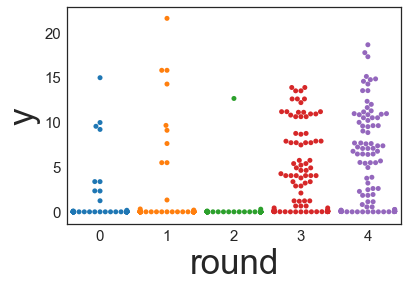

In [56]:
_ = sns.swarmplot(data=df, x='round', y='y')

In [52]:
[max(yy) for yy in y_sampled]

[1.175220660068953,
 1.334396682952795,
 1.1022292926574533,
 1.1423527628399934,
 1.2706665996001771]

In [57]:
[opt.get_N(lib, L) for lib in libraries]

[5760, 3402, 60, 180]